ARIMA
<p/>
Michael Langst
<p/>


### Part I:  Research Question




#### A 1. Research Question
A question about the research covered in this study is, does the data provide sufficient indicators to forecast what will likely happen next in the time series?

#### A 2. Objectives

The primary goal of this study is to justify proof that an ARIMA model can predict a future point in a time series dataset. This will be accomplished by following the necessary steps to transform the data and test the accuracy of the ARIMA outcome. 

### Part II:  Method Justification




Time series is a methodology to forecast the future using an independent variable of time paired with the predicted data. When the statistical properties do not change over time, it has stationarity. Stationarity consists of a mean and variance that remains constant throughout the series of data in time. The covariance also remains independent of time in a stationarity model. A study of the time lag between time-series observations and measuring their similarity is called autocorrelation. The comments made about the periodic fluctuations over time are the basis of detecting seasonality within the data. (Peixeiro 2019)

<p/>

Detecting the stationarity of data is performed by the Dickey-Fuller test. This hypothesis test decides between a p-value being either less than or equal to zero. For example, if p>0, the time series is not stationary; otherwise, p=0 and the series are stationary. (Peixeiro 2019)

<p/>

For this case study, we will use an Auto-Regressive Integrated Moving Average (ARIMA) model to forecast the time series dataset because it is helpful to generalize non-stationary time series data. Auto-Regression is a specialization of the regression model where the dependent variable uses past instances of itself while moving average measures the degree of error in past predictions to become more accurate. Integrated is understood as a transformation applied to non-constant data to establish stationarity. The mean and variance then become constant while the model observes the differences between series to forecast these differences in the future. (Rajbhoj 2019)

<p/>

Note: ARIMA does not do well with seasonal data; the Seasonal ARIMA model would be used instead.


 ### Part III: Data Preparation

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore Warning Code

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data set
series = pd.read_csv('teleco_time_series .csv')
# check null values

In [3]:
series.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


#### C 1.  Line graph of time series.

#### Moving Average

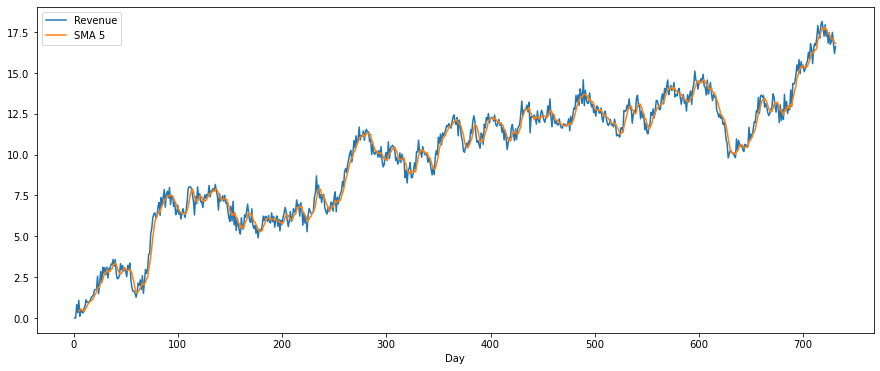

In [23]:
#code (Effrosynidis 2020)

y = series[['Day','Revenue']]
y = y.set_index('Day')
y['SMA 5'] = y.rolling(window=5).mean() 
y.plot(figsize=(15,6));

#### C 2. Time step formatting.

In [24]:

print(series.isnull().sum())

Day        0
Revenue    0
dtype: int64


No missing data is present.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

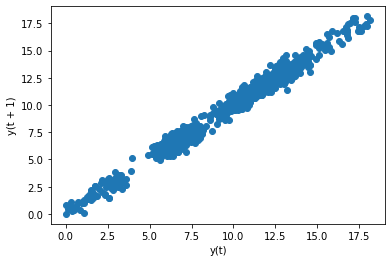

In [25]:
#code (Effrosynidis 2020)
from pandas.plotting import lag_plot

lag_plot(series['Revenue'])


#### Interpreting the lag-scatter plot

<p/>

* If the points cluster alongside a diagonal line from the bottom-left to the top-right of the plot, it implies a positive correlation affiliation.

<p/>

* If the points cluster alongside a diagonal line from the top-left to the bottom-right, it advocates a negative correlation association.

<p/>

* Either relationship can be modeled.

<p/>

* More points tighter into the diagonal line suggests a stronger relationship, and more spread from the line indicates a weaker relationship.

<p/>

* A ball in the middle of a spread across the plot suggests a weak or no relationship.

<p/>

Based on the scatterplot above, the time series data is strongly and positively correlated. (Effrosynidis 2020)


#### C 3. Stationarity

In [26]:
#code (Effrosynidis 2020)

from statsmodels.tsa.stattools import adfuller
# check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
adf_test(series[['Day','Revenue']]['Revenue'],title='')        


Augmented Dickey-Fuller Test: 
ADF test statistic       -1.924612
p-value                   0.320573
# lags used               1.000000
# observations          729.000000
critical value (1%)      -3.439352
critical value (5%)      -2.865513
critical value (10%)     -2.568886
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


#### C 4. Steps used to prepare the data for analysis, including the training and test set split.

In [27]:
# code (How to convert non-stationary data into stationary for ARIMA model with python n.d.))

diff_v2 = series['Revenue'].diff().diff(12).reset_index().dropna()
time_series = series['Day']
df_diff_v2 = pd.concat([time_series, diff_v2], axis=1).reset_index().dropna()

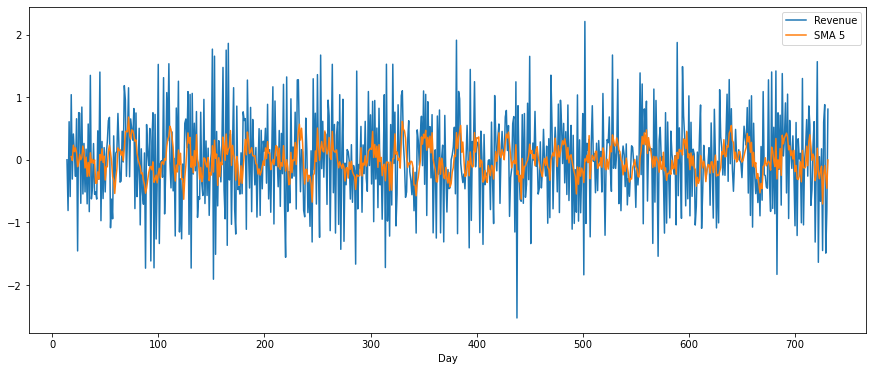

In [28]:
y = df_diff_v2[['Day','Revenue']]
y = y.set_index('Day')
y['SMA 5'] = y.rolling(window=5).mean() 
y.plot(figsize=(15,6));

In [29]:
adf_test(df_diff_v2[['Day','Revenue']]['Revenue'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.253817e+01
p-value                 2.346466e-23
# lags used             1.200000e+01
# observations          7.050000e+02
critical value (1%)    -3.439660e+00
critical value (5%)    -2.865648e+00
critical value (10%)   -2.568958e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Stationarity is now established with the dataset _df_diff_v2_.

#### C 5.  Copy of the cleaned dataset.

In [30]:
#Prepared data set saved

df_diff_v2=df_diff_v2.drop(['level_0', 'index'], axis = 1)
df_diff_v2=df_diff_v2.reset_index(drop=True)

df_diff_v2.to_csv('Cleaned_stationary_data.csv')

### Part IV: Model Identification and Analysis

#### Presence or lack of a seasonal component.

<AxesSubplot:>

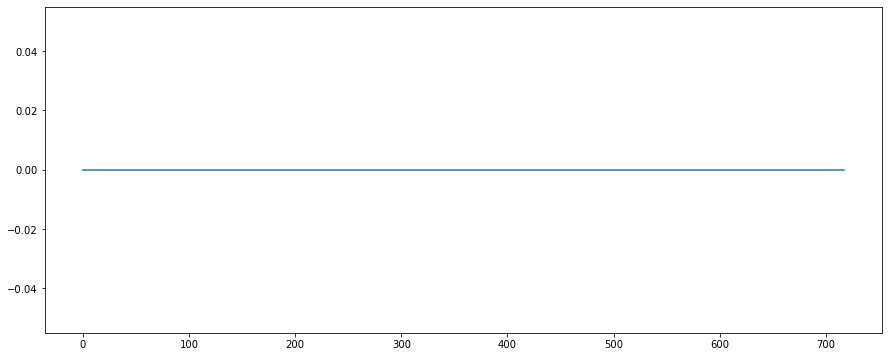

In [31]:
#code (Yoss 2020)
# Import
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose time series into daily trend, seasonal, and residual components.
# Note that the settlement price = average daily price.
decomp = seasonal_decompose(df_diff_v2['Revenue'], period = 1)
# Plot the seasonal time series to interpret.
decomp.seasonal.plot(figsize=(15,6))

There is no apparent sign of seasonality in the plot.

#### Trends

<AxesSubplot:>

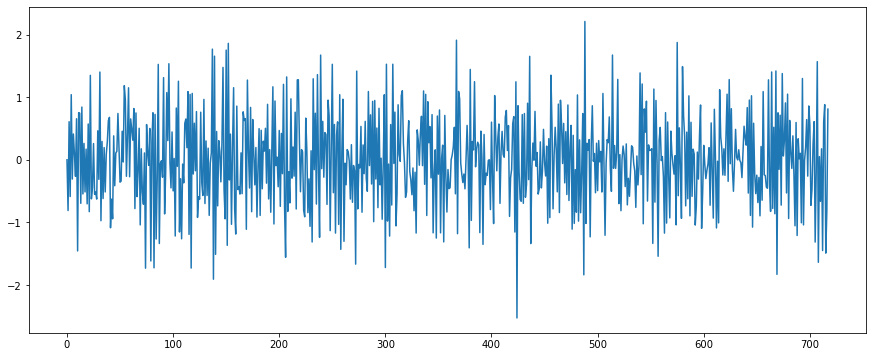

In [32]:
#code (Yoss 2020)
# Trend Plot
decomp.trend.plot(figsize=(15, 6))

Data is stationary.

#### Auto correlation function

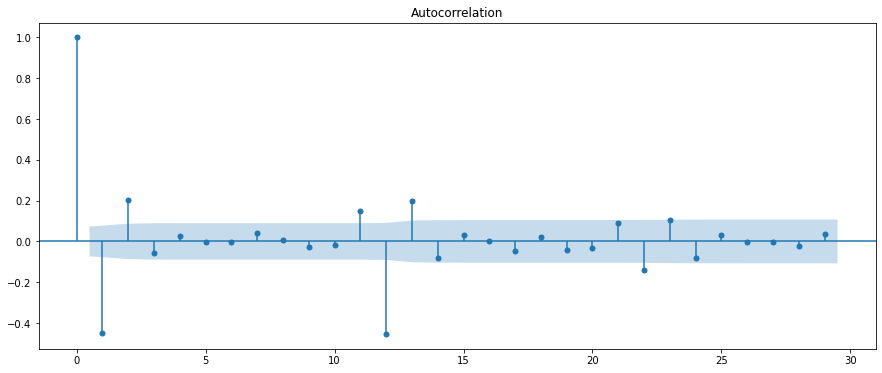

In [33]:
# code(Mallick 2020)

from statsmodels.graphics.tsaplots import plot_acf

df_diff_v2['Revenue'].iloc[0] = 0
plot_acf(df_diff_v2['Revenue']).set_size_inches(15, 6)
plt.show()

6 points outside the cone appear to be significant lag.

#### Spectral density

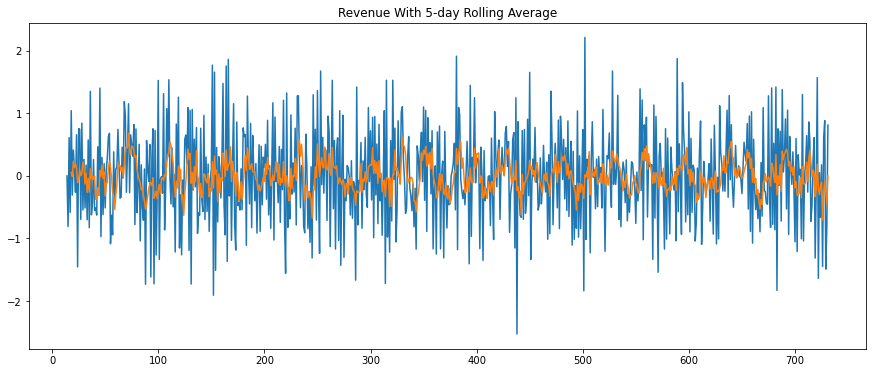

In [34]:
#code (Nik 2020)
# Calculating a Rolling Mean with Pandas
df_diff_v2['Rolling'] = df_diff_v2['Revenue'].rolling(5).mean()
plt.rcParams['figure.figsize'] = [15, 6]

# Plotting the effect of a rolling average
plt.plot(df_diff_v2['Day'], df_diff_v2['Revenue'])
plt.plot(df_diff_v2['Day'], df_diff_v2['Rolling'])
plt.title('Revenue With 5-day Rolling Average')

plt.show()

#### Decomposed time series

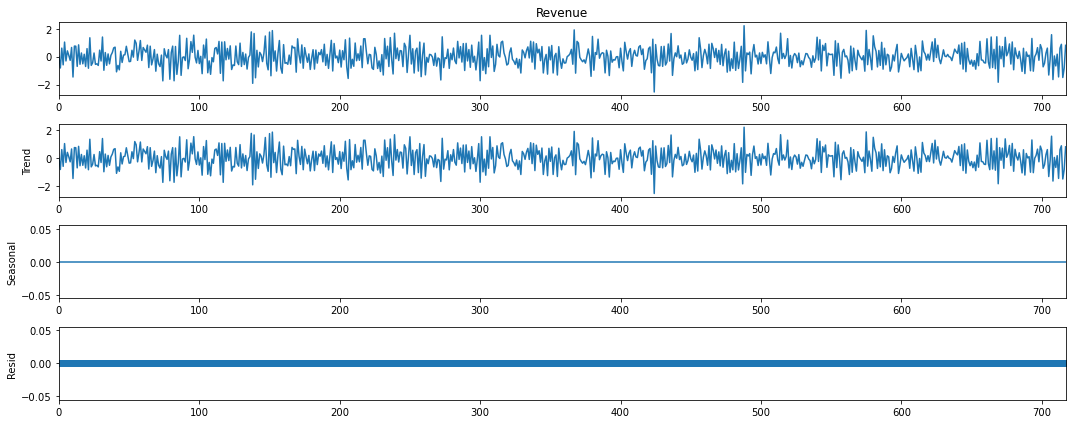

In [35]:
# Plot the decomposed time series to interpret
decomp.plot().set_size_inches(15, 6)

#### Confirmation of the lack of trends in the residuals of the decomposed series

<AxesSubplot:>

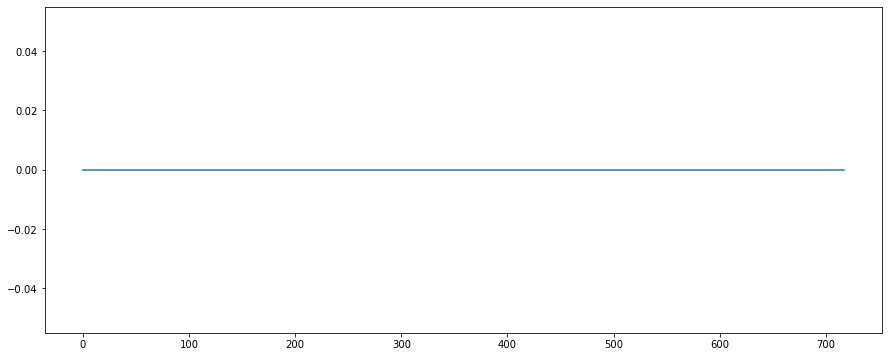

In [36]:
#residuals of the decomposed series
decomp.resid.plot(figsize=(15, 6))

Residuals are not trending.

#### D 2. (ARIMA) model

In [37]:

# code (Khan 2021)
from statsmodels.tsa.arima_model import ARIMA
# ARIMA order (p,d,q)
model = ARIMA(df_diff_v2['Revenue'], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.Revenue   No. Observations:                  717
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -735.478
Method:                       css-mle   S.D. of innovations              0.671
Date:                Sat, 09 Apr 2022   AIC                           1480.956
Time:                        00:31:35   BIC                           1503.831
Sample:                             1   HQIC                          1489.789
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.156e-05   8.37e-05     -0.138      0.890      -0.000       0.000
ar.L1.D.Revenue    -0.4536      0.069     -6.603      0.000      -0.588      -0.319
ma.L1.D.Revenue    -0.9942      

#### D 3. Forecast

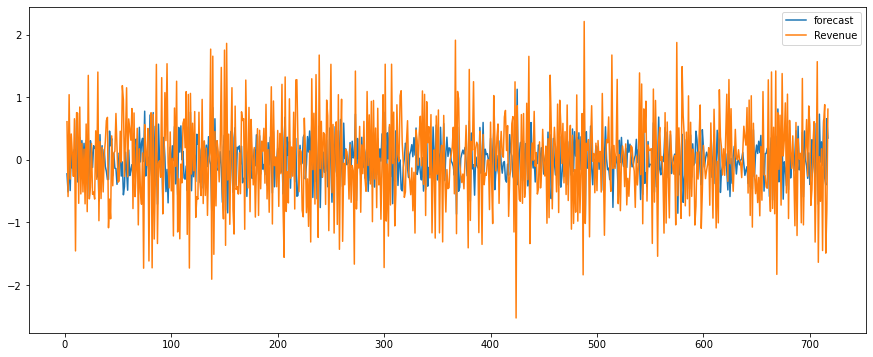

In [38]:
# code (Khan 2021)
model_fit.plot_predict(dynamic=False)
plt.show()

#### ARIMA Model Accuracy with MAPE

In [39]:
# code (Khan 2021)

from sklearn.model_selection import train_test_split
# split the data into train and test set
train, test = train_test_split(df_diff_v2['Revenue'], test_size=0.3, random_state=42)

model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit(disp=-1)
# Forecast
fc, se, conf = fitted.forecast(1, alpha=0.05)
mape = np.mean(np.abs(fc - test)/np.abs(test))  # MAPE
accuracy=100-mape

print('The MAPE is {:.2f}'.format(mape) + ', that means the model accuracy is {:.2f}'.format(accuracy)+ ' %')

The MAPE is 1.46, that means the model accuracy is 98.54 %


That is pretty good, the ARIMA model is fairly accurate. 

### Part V:  Data Summary and Implications

Once the data is loaded a simple moving average is used to view the time series as a smooth average and show its trends.  The data is then plotted in a scatter plot to view the lag within it and it is determined that the time series data is strongly and positively correlated. An Augmented Dickey-Fuller test is applied to the data and confirms it is not stationary. So, the information is then transformed into stationary data and plotted with a rolling average followed by a confirmation from an additional Augmented Dickey-Fuller test that the dataset is stationary. 

<p/>

After saving a modified copy of the data, it is checked for seasonality and confirmed not to be present. Following proof that no trends exist in the data is displayed and followed by an auto correlation function to represent which determine there are six points outside the blue cone and identified as significant lag. Finally, a 5-day rolling average is compared to the stationary data followed by decomposed time series and confirmation no trends in the data are present. 

<p/>

The data is then fitted to the ARIMA model and displayed as a forecast with the stationary data in a line graph.  Finally, accuracy is tested with mean absolute percentage error (MAPE) and determined that the model is 98.54 % accurate at forecasting using the entire dataset length for both forecast length and the prediction interval.  A business decision may be easily reach to use these results if this model is tested against unseen data in the future and proven as accurate. 


### Sources

<p/> 

Brownlee, J. (2017, January 3). Time Series Data Visualization with Python. Machine Learning Mastery. https://machinelearningmastery.com/time-series-data-visualization-with-python/

<p/>

Effrosynidis, D. (2020, April 6). Time Series Analysis with Theory, Plots, and Code Part 2. Medium. https://towardsdatascience.com/time-series-analysis-with-theory-plots-and-code-part-2-c72b447da634

<p/>

How to convert non-stationary data into stationary for ARIMA model with python. (n.d.). Tobi Olabode. Retrieved April 7, 2022, from https://www.tobiolabode.com/blog/2020/12/30/how-to-convert-non-stationary-data-into-stationary-for-arima-model-with-python

<p/>

Khan, E. (2021, February 1). Python Code on ARIMA Forecasting. Analytics Vidhya. https://medium.com/analytics-vidhya/python-code-on-arima-forecasting-d6e2fd90697c

<p/>


Mallick, D. (2020, November 25). Interpreting ACF or Auto-correlation plot. Analytics Vidhya. https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14

<p/>

Nik. (2020, July 27). Calculate a Rolling Average (Mean) in Pandas • datagy. Datagy. https://datagy.io/rolling-average-pandas/

<p/>

Peixeiro, M. (2019, August 7). The Complete Guide to Time Series Analysis and Forecasting. Medium; Towards Data Science. https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

<p/>

Rajbhoj, A. (2019, October 4). ARIMA simplified. Medium. https://towardsdatascience.com/arima-simplified-b63315f27cbc

<p/>

Yoss, A. (2020, April 20). Time Series Seasonal Decomposition. The Startup. https://medium.com/swlh/time-series-seasonal-decomposition-a300fe0f34dd